In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
from PIL import Image, ImageColor
from pathlib import Path

import torch
import torch.nn.functional as F
import torch.nn as nn

from torch import tensor
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, TensorDataset

import torch.distributions.constraints as constraints
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='Set2')
import time

# !pip install -q torchsummary
# from torchsummary import summary

import pandas as pd
from tqdm import tqdm

from IPython.display import clear_output


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


### 1. Load Colored MNIST dataset

In [67]:
# NO COUNTERFACTUAL!!!!
colors = [
        'darkgreen', '#6495ed', 'darkblue', '#b03060',
        'orangered', 'yellow', 'burlywood', 'lime',
        'aqua', 'fuchsia',
    ]
color_names = ['darkgreen', 'blue', 'darkblue', 'maroon', 'orangered',
            'yellow', 'burlywood', 'lime', 'aqua', 'fuchsia']
color_dict = {k: v for k, v in enumerate(color_names)}

def get_rgb(x):
    t = torch.tensor(ImageColor.getcolor(x, "RGB")) / 255.
    return t.view(-1, 1, 1)

NUM_COLORS = len(colors)
colors = list(map(get_rgb, colors))
# COUNTERFACTUAL_LABELS = [0,2,4,6,8]

class DoubleColoredMNIST(Dataset):
    def __init__(self, train=True):
        self.train = train
        self.mnist_sz = 28

        # get mnist
        if train:
            mnist = datasets.MNIST(root='data', download=True, train=True)
        else:
            mnist = datasets.MNIST(root='data', download=True, train=False)
        ims, labels = mnist.data, mnist.targets
        self.T = transforms.Compose([
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        self.ims_digit = torch.stack([ims, ims, ims], dim=1)
        self.labels = labels

    def __getitem__(self, idx):
        digit = self.labels[idx]
        fg_i = np.random.choice(NUM_COLORS)
        bg_i = np.random.choice([i for i in range(NUM_COLORS) if i != fg_i])
        back_color = colors[bg_i].clone()
        back_color += torch.normal(0, 1e-3, (3, 1, 1))
        obj_color = colors[fg_i].clone()
        obj_color += torch.normal(0, 1e-3, (3, 1, 1))

        # get digit
        im_digit = (self.ims_digit[idx] / 255.).to(torch.float32)
        im_digit = F.interpolate(im_digit[None,:], (self.mnist_sz, self.mnist_sz)).squeeze()
        im_digit = (im_digit > 0.1).to(int)  # binarize

        # plot digit onto the texture
        ims = im_digit * (obj_color) + (1 - im_digit) * back_color

        ret = {
            'img': self.T(ims),
            'label': np.array([digit, fg_i, bg_i], dtype=int),
        }
        return ret

    def __len__(self):
        return self.labels.shape[0]

In [69]:
LABEL_SIZES = [10, NUM_COLORS, NUM_COLORS]
LABEL_NAMES = ['digit', 'obj_color', 'bg_color']
dataset_train = DoubleColoredMNIST(train=True)
dataset_test = DoubleColoredMNIST(train=False)
print(len(dataset_train), len(dataset_test))
print(LABEL_SIZES)

60000 10000
[10, 10, 10]


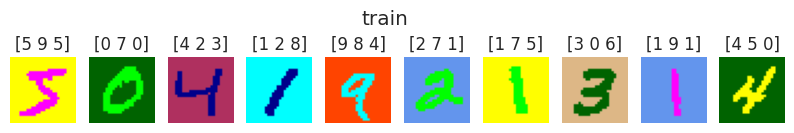

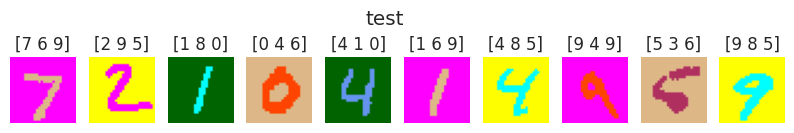

In [71]:
def normalize(img):
    a = np.expand_dims([0.5, 0.5, 0.5], (0,1))
    normalized = img * a + a
    return normalized.clip(0, 1)

for n, dataset in zip(['train', 'test'], [dataset_train, dataset_test]):
    plt.figure(figsize=(10, 2))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        sample = dataset[i]
        plt.imshow(normalize(sample['img'].permute(1, 2, 0)))
        plt.title(str(sample['label']))
        plt.axis('off')
    plt.suptitle(n, y=.9)
    plt.show()

In [72]:
from sklearn.model_selection import train_test_split
dataset_train, dataset_val = train_test_split(dataset_train, test_size=0.25, random_state=42)
BATCH_SIZE = 256
train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
val_loader = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True)

### 2. Train Classifier

In [25]:
!pip install -q torchinfo
from torchinfo import summary

In [75]:
device = f"cuda" if torch.cuda.is_available() else "cpu"
simple_cnn = nn.Sequential(
    nn.Conv2d(3, 32, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Conv2d(32, 64, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.4),
    nn.Flatten(),
    nn.Linear(in_features=1024, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=30)
).to(device)

In [76]:
summary(simple_cnn, input_size=(1, 3, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 30]                   --
├─Conv2d: 1-1                            [1, 32, 24, 24]           2,432
├─ReLU: 1-2                              [1, 32, 24, 24]           --
├─MaxPool2d: 1-3                         [1, 32, 12, 12]           --
├─ReLU: 1-4                              [1, 32, 12, 12]           --
├─Dropout: 1-5                           [1, 32, 12, 12]           --
├─Conv2d: 1-6                            [1, 64, 8, 8]             51,264
├─ReLU: 1-7                              [1, 64, 8, 8]             --
├─MaxPool2d: 1-8                         [1, 64, 4, 4]             --
├─Dropout: 1-9                           [1, 64, 4, 4]             --
├─Flatten: 1-10                          [1, 1024]                 --
├─Linear: 1-11                           [1, 256]                  262,400
├─ReLU: 1-12                             [1, 256]                  --
├─L

In [77]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
def plot_histories(histories, names):
    sns.set_style('darkgrid')
    colors = ['darkblue', 'lightcoral', 'limegreen', 'sandybrown']
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    epochs = np.min([len(h['loss']['train']) for h in histories])
    for i, (history, name) in enumerate(zip(histories, names)):
        axs[0].set_title('Лосс')
        axs[0].plot(history['loss']['train'][:epochs], label=f'{name}', lw=2, c=colors[i])
        axs[0].plot(history['loss']['val'][:epochs], lw=1.5, c=colors[i], ls='--')
        axs[0].set_xlabel('Эпохи')

        axs[1].set_title('Точность')
        axs[1].plot(history['acc']['train'][:epochs], label=f'{name}', lw=2, c=colors[i])
        axs[1].plot(history['acc']['val'][:epochs], lw=1.5, c=colors[i], ls='--')
        axs[1].set_xlabel('Эпохи')
        axs[1].legend()

    dummy_lines = [axs[0].plot([], [], c='black', lw=2)[0],
                   axs[0].plot([], [], c='black', lw=1.5, ls='--')[0]]
    for i in range(2):
        legend = axs[i].legend(loc=3-i)
        axs[i].legend(dummy_lines, ["train", "val"], loc=4)
        axs[i].add_artist(legend)
    plt.show()

def print_epoch(epoch, num_epochs, history, t):
    clear_output(wait=True)
    print("Epoch {} of {} took {:.3f} s".format(epoch + 1, num_epochs, t))
    print("  training loss: \t{:.6f}".format(history['loss']['train'][-1]))
    print("  validation loss: \t{:.6f}".format(history['loss']['val'][-1]))
    print("  training accuracy: \t\t\t{:.2f} %".format(history['acc']['train'][-1] * 100))
    print("  validation accuracy: \t\t\t{:.2f} %".format(history['acc']['val'][-1] * 100))


def update_history(history, loss, acc, num_batches, mode):
    loss /= num_batches
    acc /= num_batches
    history['loss'][mode].append(loss)
    history['acc'][mode].append(acc)


def get_batch_loss(X_batch, y_batch, model, criterion, current_loss, current_acc):
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    logits = model(X_batch) # (BS, 30)
    loss = criterion(logits[:, :10], y_batch[:, 0].long().to(device))
    loss += criterion(logits[:, 10:20], y_batch[:, 1].long().to(device))
    loss += criterion(logits[:, 20:], y_batch[:, 2].long().to(device))
    current_loss += loss.detach().cpu().numpy()
    y_pred = [logits[:, i * 10 : (i+1) * 10].max(1)[1].detach().cpu().numpy() for i in range(3)]
    y_pred = np.stack(y_pred).T
    current_acc += np.mean(y_batch.cpu().numpy() == y_pred)
    return loss, current_loss, current_acc


def train(model, criterion, optimizer,
          train_batch_gen, val_batch_gen, num_epochs=40, history=None):
    if history is None:
        history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss, val_loss = 0, 0
        train_acc, val_acc = 0, 0
        start_time = time.time()

        model.train(True)
        for batch in train_batch_gen:
            loss, train_loss, train_acc = get_batch_loss(batch['img'], batch['label'], model, criterion, train_loss, train_acc)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        update_history(history, train_loss, train_acc, len(train_batch_gen), 'train')
        model.train(False)
        with torch.no_grad():
            for batch in val_batch_gen:
                _, val_loss, val_acc = get_batch_loss(batch['img'], batch['label'], model, criterion, val_loss, val_acc)

        update_history(history, val_loss, val_acc, len(val_batch_gen), 'val')
        print_epoch(epoch, num_epochs, history, time.time() - start_time)
    return history

In [80]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(simple_cnn.parameters(), lr=1e-3)

history_cnn = train(
    simple_cnn, criterion, optimizer,
    train_loader, val_loader, 20)
torch.save(simple_cnn.state_dict(), '/content/drive/MyDrive/thesis/classifier.pth')

Epoch 20 of 20 took 49.098 s
  training loss: 	0.098604
  validation loss: 	0.082166
  training accuracy: 			98.91 %
  validation accuracy: 			99.21 %


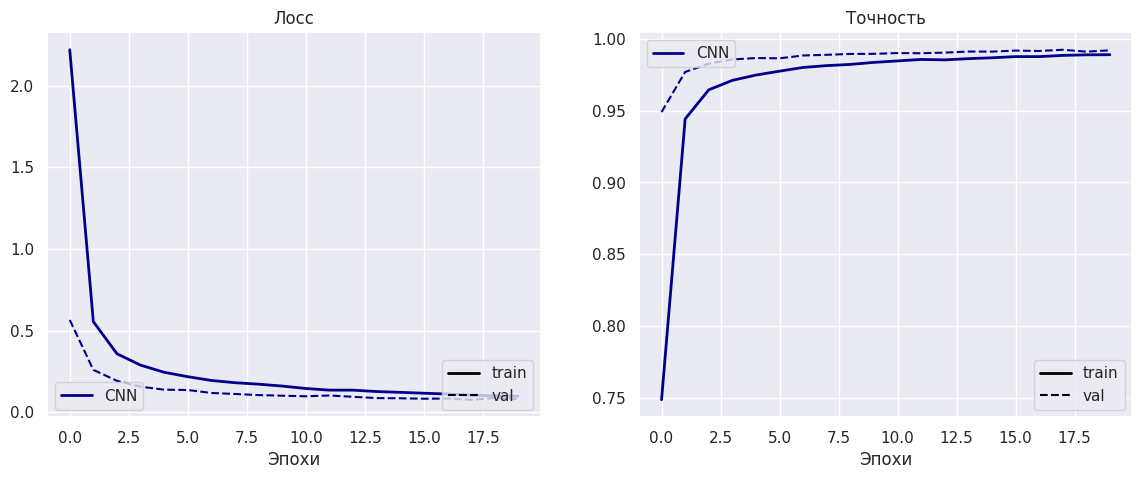

In [81]:
plot_histories([history_cnn], ['CNN'])

### 3. Inference

In [100]:
# test
batch = next(iter(test_loader))
ids = np.random.choice(len(batch['img']), 10, replace=False)
X_batch = batch['img'][ids].to(device)
y_batch = batch['label'][ids].to(device)
logits = simple_cnn(X_batch) # (BS, 30)
y_pred = [logits[:, i * 10 : (i+1) * 10].max(1)[1].detach().cpu().numpy() for i in range(3)]
y_pred = np.stack(y_pred).T

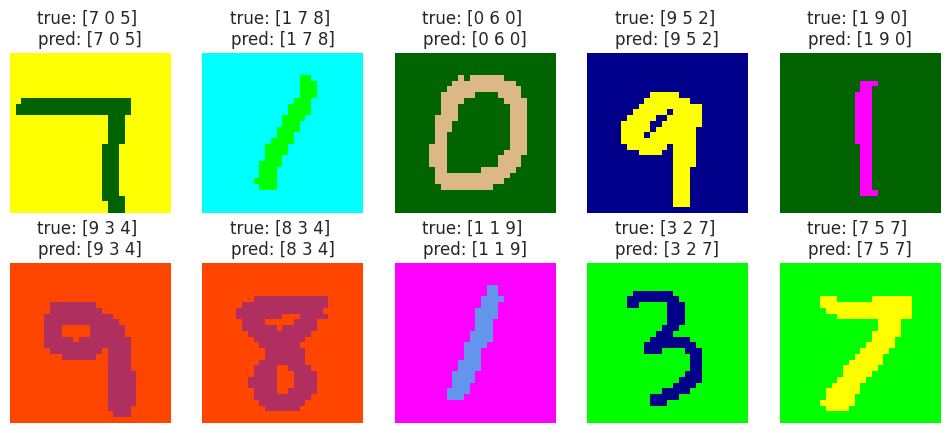

In [111]:
fig, ax = plt.subplots(2, 5, figsize=(12, 5))
ax = ax.flatten()
for i, (x, pred, real) in enumerate(zip(X_batch, y_pred, y_batch)):
    ax[i].imshow(normalize(x.permute(1, 2, 0)))
    ax[i].axis('off')
    ax[i].set_title('true: ' + str(real.numpy()) + " \npred: " + str(pred))